# Sistema de recomendação de filmes usando SVD

Desenvolvido por:

* Gustavo Henrique Brunelli (11801053)
* Matheus Ventura de Sousa (11345541)
* Pedro Lucas de Moliner de Castro (11795784)
* João Guilherme Jarochinski Marinho (10698193)
* Matheus Henrique de Cerqueira Pinto (11911104)

Disciplina de Cálculo Numérico (SME0104) para o curso de Ciências de Computação, ministrado no ICMC/USP, durante o primeiro semestre de 2022.

---

# Teoria

## Sistemas de recomendação

Sistemas de recomendação, ou *Recommender Systems* (**RSs**) são modelos com função de coletar informações de preferências de um grupo de usuários acerca de um conjunto determinado de itens. Esse tipo de informação pode ser obtida **explicitamente**, como através do armazenamento de avaliações de usuários ou **implicitamente**, usando técnicas de monitoramento em sistemas. Com o aumento exponencial do número de dados produzidos com a popularização da Internet, tornaram-se cada vez mais importantes, tanto comercial quanto cientificamente (BOBADILLA, 2013).


## SVD

O método de *Singular Value Decomposition* (**SVD**) é uma técnica que consiste na decomposição de uma matriz $R$ em duas matrizes unitárias $U$ e $V^T$ e uma matriz diagonal $\Sigma$, de forma que:

$$R=U \Sigma V^T$$

Sob o contexto de sistemas de recomendação, o SVD consiste em construir, a partir de um grupo de usuários e sua relação com um conjunto de itens (como avaliações em filmes, por exemplo), um grupo de predições apropriadas a partir das características mais latentes da relação (BECKER, 2013).

---

# Implementação

Para a implementação dos conceitos estudados, foi proposta a construção de um sistema de recomendação de filmes baseado em avaliações de usuários que, aparentemente, é uma aplicação inicial comum para a temática. Para isso, foi usada uma das bases de dados do projeto MovieLens, com 1 milhão de registros, disponibilizada publicamente pelo GroupLens, da Universidade de Minnesota (Movielens, 2021). A base consistia em dois arquivos .dat: um com filmes e seus respectivos títulos e gêneros e outro com avaliações de usuário.

Foi observado, inicialmente, o artigo de Chen (2019), que dispunha de uma análise mais simples sobre Sistemas de Recomendação, sem uso de bibliotecas, mas realizando operações através de matrizes. A partir disso, então, para embasamento prático, foram observadas propostas similares de construção de sistemas de recomendação, como a aplicação de Meng (2021), com caráter mais introdutório e, também, de Becker (2016), mais robusta focada na aplicação do SVD através de bibliotecas, como NumPy e SciPy, combinada à explicação de funcionalidades gerais.

## 1. Preparação do ambiente

In [1]:
# Importa bibliotecas úteis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds

### 1.1 Lendo e interpretando as bases de dados

Os dados foram manualmente alterados devido à problemas de leitura usando diretamente o formato .dat. Assim, as linhas foram convertidas para um padrão analisável de .csv e realocadas sob a pasta /data do presente trabalho.

In [2]:
# Lê as bases de dados de filmes e avaliações de usuário
filmes = pd.read_csv("data/movies.csv", encoding = "ISO-8859-1")
uavals = pd.read_csv("data/ratings.csv", encoding = "ISO-8859-1")

In [3]:
# Mostra a estrutura da base de filmes
filmes.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children's
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [4]:
# Mostra a estrutura da base de avaliações
uavals.head(10)

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
5,1,1197,3,978302268
6,1,1287,5,978302039
7,1,2804,5,978300719
8,1,594,4,978302268
9,1,919,4,978301368


In [5]:
# Exibe os tamanhos dos DataFrames
print("São", len(filmes), "filmes e", len(uavals), "avaliações no total.")

São 3883 filmes e 1000209 avaliações no total.


### 1.2 Criando o DataFrame relacionando usuários e avaliações

In [6]:
# Constrói um DataFrame usuário x filme com base nas avaliações
# Filmes avaliados recebem a avaliação e não avaliados 0
uaval_filme = uavals.pivot(index = "userId", columns = "movieId", values = "rating").fillna(0)

In [7]:
# Visualização do DataFrame gerado
uaval_filme.head(10)

movieId,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
userId,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0


Ao fim desse passo, foi criada uma matriz $M_{usuarios\times filmes}$, completando com 0 aqueles filmes ainda não avaliados pelo usuário.

## 2. Construção do sistema de recomendação

### 2.1 Tratamento da matriz de avaliações

A primeira etapa de tratamento consistiu em normalizar as avaliações de cada usuário através da média geral das avaliações por ele realizadas.

In [8]:
# Converte o DataFrame numa matriz
matriz = uaval_filme.values

# Constrói um array de médias de avaliação para cada usuário
uaval_medias = np.mean(matriz, axis = 1)

# Normaliza as avaliações de cada usuário com base na média
matriz_norm = matriz - uaval_medias.reshape(-1, 1)

In [9]:
# Exibe a matriz original
print(matriz)

[[5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [3. 0. 0. ... 0. 0. 0.]]


In [10]:
# Exibe a matriz normalizada
print(matriz_norm)

[[ 4.94009714 -0.05990286 -0.05990286 ... -0.05990286 -0.05990286
  -0.05990286]
 [-0.12924987 -0.12924987 -0.12924987 ... -0.12924987 -0.12924987
  -0.12924987]
 [-0.05369671 -0.05369671 -0.05369671 ... -0.05369671 -0.05369671
  -0.05369671]
 ...
 [-0.02050729 -0.02050729 -0.02050729 ... -0.02050729 -0.02050729
  -0.02050729]
 [-0.1287102  -0.1287102  -0.1287102  ... -0.1287102  -0.1287102
  -0.1287102 ]
 [ 2.6708041  -0.3291959  -0.3291959  ... -0.3291959  -0.3291959
  -0.3291959 ]]


### 2.2 Utilizando o SVD

Para a execução do SVD, optou-se por usar a função svds do SciPy, pois permite a definição do número de fatores. Pela definição da função:

>Computa $k$ SVDs para uma matriz e retorna $U$ uma matriz unitária tendo os valores singulares à esquerda como colunas, $s$ um vetor com os valores singulares e $V^t$ uma matriz unitária tendo os valores singulares à direita como linhas.

In [11]:
# Calcula o SVD com 50 fatores
U, sing_vals, Vt = svds(matriz_norm, k = 50)

Como a função retorna $s$ apenas como um array, é necessário transformá-lo numa matriz diagonal $\Sigma$:

In [12]:
# Converte para a forma diagonal
sing_vals_diag = np.diag(sing_vals)

In [13]:
# Exibe a matriz gerada
sing_vals_diag

array([[ 147.18581225,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,  147.62154312,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,  148.58855276, ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [   0.        ,    0.        ,    0.        , ...,  574.46932602,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
         670.41536276,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        , 1544.10679346]])

Ao final desse passo, todos os componentes esperados estão prontos para a aplicação.

### 2.3 Construção da recomendação

#### 2.3.1 Preparação dos dados

Nesse passo, construímos a fórmula do SVD realizando as multiplicações necessárias, tal que:
$$R=U \Sigma V^t$$

In [14]:
# Cria uma matriz de predição
uavals_matriz_pred = np.dot(np.dot(U, sing_vals_diag), Vt) + uaval_medias.reshape(-1, 1)

# Padroniza os valores
uavals_matriz_pred[uavals_matriz_pred < 0] = 0
for i in range(6):
    uavals_matriz_pred[(uavals_matriz_pred > i) & (uavals_matriz_pred < (i + 1))] = i + 1

Com a matriz construída, basta organizá-la num DataFrame:

In [15]:
# Cria um DataFrame da predição 
# Usa os dados da matriz e as colunas do DataFrame original
uavals_pred = pd.DataFrame(
    uavals_matriz_pred, 
    columns = uaval_filme.columns
)

In [16]:
# Exibe o DataFrame
uavals_pred.head(10)

movieId,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,5.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,2.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
5,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
6,1.0,1.0,1.0,1.0,0.0,2.0,0.0,1.0,0.0,2.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
7,1.0,1.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,4.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,2.0,1.0,1.0,0.0,1.0
9,5.0,3.0,2.0,1.0,2.0,0.0,2.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0


Ao final desse passo, todos os filmes têm uma predição realiada, independentemente de já ter sido avaliado anteriormente ou não.

#### 2.3.2 Função de recomendação

Com as predições, é necessário criar uma função de recomendação que ignore os filmes já avaliados e que organize os resultados de forma decrescente para, então, realmente configurar uma recomendação.

In [17]:
def recomendar(id_usuario, n_recomendacoes = 10):
    """
    Recebe um ID de usuário e um número de recomendações (padrão=10)
    Retorna um DataFrame de filmes já assistidos e um DataFrame de recomendações
    """
    
    # Lista de forma decrescente as predições para o usuário
    upred_valores = uavals_pred.iloc[id_usuario - 1].sort_values(ascending = False)
    upred = pd.DataFrame(upred_valores).reset_index()

    # Recupera os filmes avaliados por um usuário e adiciona as informações
    ufilmes = (uavals[uavals.userId == (id_usuario)]).merge(
        filmes,
        how = "left",
        left_on = "movieId",
        right_on = "movieId"
    ).sort_values(["rating", "title"], ascending = [False, True])

    # Separa os filmes ainda não avaliados
    nao_aval = filmes[~filmes["movieId"].isin(ufilmes["movieId"])]

    # Organiza as recomendações com as predições
    urecomendacoes = nao_aval.merge(
        upred, 
        how = "left",
        left_on = "movieId",
        right_on = "movieId"
    )

    # Organiza descendentemente as recomendações
    urecomendacoes = (urecomendacoes.rename(
        columns = {id_usuario - 1: "val_pred"}
    ).sort_values(["val_pred", "title"], ascending = [False, True]))

    urecomendacoes["val_pred"] = urecomendacoes["val_pred"].fillna(0)

    return ufilmes, urecomendacoes.head(n_recomendacoes)

Ao final desse passo, a função que era o objetivo do trabalho está finalizada. São retornados os filmes avaliados e as recomendações organizados decrescentemente por avaliação.

### 3. Recomendando filmes

#### 3.1 Para o usuário 22

In [18]:
# Realiza a recomendação de 10 filmes para o usuário 22
filmes_22, recomendacoes_22 = recomendar(22)

In [19]:
# Visualiza os filmes avaliados pelo usuário 22
filmes_22

,userId,movieId,rating,timestamp,title,genres
261,22,1225,5,978135474,Amadeus (1984),Drama
183,22,2858,5,978134744,American Beauty (1999),Comedy|Drama
220,22,608,5,978135545,Fargo (1996),Crime|Drama|Thriller
167,22,3578,5,978134462,Gladiator (2000),Action|Drama
131,22,2324,5,978134977,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama
...,...,...,...,...,...,...
202,22,3300,1,978134462,Pitch Black (2000),Action|Sci-Fi
178,22,2273,1,978136925,Rush Hour (1998),Action|Thriller
188,22,377,1,978136719,Speed (1994),Action|Romance|Thriller
272,22,2393,1,978154862,Star Trek: Insurrection (1998),Action|Sci-Fi


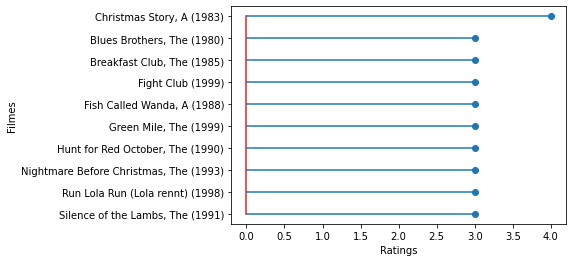

In [20]:
# Visualiza as recomendações para o usuário 22
aux = recomendacoes_22.sort_values(by = ["val_pred", "title"], ascending = [True, False])
plt.stem(aux["val_pred"], orientation = "horizontal")
plt.yticks(range(len(aux["title"])), aux["title"])
plt.xlabel("Ratings")
plt.ylabel("Filmes")
plt.show()

In [21]:
# Visualiza as recomendações para o usuário 22
recomendacoes_22

,movieId,title,genres,val_pred
2492,2804,"Christmas Story, A (1983)",Comedy|Drama,4.0
1097,1220,"Blues Brothers, The (1980)",Action|Comedy|Musical,3.0
1731,1968,"Breakfast Club, The (1985)",Comedy|Drama,3.0
2643,2959,Fight Club (1999),Drama,3.0
972,1079,"Fish Called Wanda, A (1988)",Comedy,3.0
2818,3147,"Green Mile, The (1999)",Drama|Thriller,3.0
1422,1610,"Hunt for Red October, The (1990)",Action|Thriller,3.0
490,551,"Nightmare Before Christmas, The (1993)",Children's|Comedy|Musical,3.0
2391,2692,Run Lola Run (Lola rennt) (1998),Action|Crime|Romance,3.0
526,593,"Silence of the Lambs, The (1991)",Drama|Thriller,3.0


#### 3.2 Para o usuário 13

In [22]:
# Realiza a recomendação de 10 filmes para o usuário 13
filmes_13, recomendacoes_13 = recomendar(13, 10)

In [23]:
# Visualiza os filmes avaliados pelo usuário 13
filmes_13

,userId,movieId,rating,timestamp,title,genres
27,13,1287,5,978202219,Ben-Hur (1959),Action|Adventure|Drama
52,13,421,5,978202491,Black Beauty (1994),Adventure|Children's
100,13,1097,5,978201368,E.T. the Extra-Terrestrial (1982),Children's|Drama|Fantasy|Sci-Fi
79,13,1204,5,978202201,Lawrence of Arabia (1962),Adventure|War
21,13,2571,5,978201740,"Matrix, The (1999)",Action|Sci-Fi|Thriller
...,...,...,...,...,...,...
72,13,60,2,978202491,"Indian in the Cupboard, The (1995)",Adventure|Children's|Fantasy
60,13,368,2,978201969,Maverick (1994),Action|Comedy|Western
51,13,3494,2,978202393,True Grit (1969),Adventure|Western
59,13,2414,2,978202433,Young Sherlock Holmes (1985),Action|Adventure|Mystery


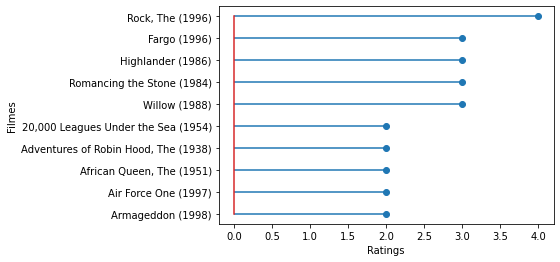

In [24]:
# Visualiza as recomendações para o usuário 13
aux = recomendacoes_13.sort_values(by = ["val_pred", "title"], ascending = [True, False])
plt.stem(aux["val_pred"], orientation = "horizontal")
plt.yticks(range(len(aux["title"])), aux["title"])
plt.xlabel("Ratings")
plt.ylabel("Filmes")
plt.show()

In [25]:
# Visualiza as recomendações para o usuário 13
recomendacoes_13

,movieId,title,genres,val_pred
695,733,"Rock, The (1996)",Action|Adventure|Thriller,4.0
576,608,Fargo (1996),Crime|Drama|Thriller,3.0
1207,1275,Highlander (1986),Action|Adventure,3.0
2255,2406,Romancing the Stone (1984),Action|Adventure|Comedy|Romance,3.0
2043,2193,Willow (1988),Action|Adventure|Fantasy,3.0
972,1019,"20,000 Leagues Under the Sea (1954)",Adventure|Children's|Fantasy|Sci-Fi,2.0
896,940,"Adventures of Robin Hood, The (1938)",Action|Adventure,2.0
924,969,"African Queen, The (1951)",Action|Adventure|Romance|War,2.0
1500,1608,Air Force One (1997),Action|Thriller,2.0
1779,1917,Armageddon (1998),Action|Adventure|Sci-Fi|Thriller,2.0


# Considerações finais

O trabalho desenvolvido foi útil para o entendimento prático de SVDs e, também, para o uso das bibliotecas e bases relacionadas. As técnicas envolvidas são relativamente simples e o resultado obtido é satisfatório. Importante é notar, no entanto, que é uma técnica computacionalmente cara; isso se fez um problema quando, de início, optou-se por usar uma base de 25M de avaliações, que resultou num gasto de memória maior que 60Gb.

# Referências

BECKER, Nick. Matrix factorization for movie recommendations in
Python. [S.l.: s.n.], nov. 2016. Disponível em:
<https://beckernick.github.io/matrix-factorization-recommender/>. Acesso em 2 dez. 2021.

BOBADILLA, J. et al. Recommender systems survey. Knowledge-Based
Systems, v. 46, p. 109–132, 2013. ISSN 0950-7051. DOI:
https://doi.org/10.1016/j.knosys.2013.03.012. Disponível em: <https:
//www.sciencedirect.com/science/article/pii/S0950705113001044>.

CHEN, Denise. Recommendation System - Matrix Factorization. [S.l.]:
Towards Data Science, jul. 2020. Disponível em:
<https://towardsdatascience.com/recommendation-system-matrixfactorization-d61978660b4b>. Acesso em 2 dez. 2021.

MENG, Memphis. Movie recommendation system based on movielens.
[S.l.]: Towards Data Science, jan. 2021. Disponível em:
<https://towardsdatascience.com/movie-recommendation-system-basedon-movielens-ef0df580cd0e>. Acesso em 2 dez. 2021.

MOVIELENS. [S.l.]: GroupLens, dez. 2021. Disponível em:
<https://grouplens.org/datasets/movielens/>. Acesso em 2 dez. 2021.

ROCCA, Baptiste. Introduction to recommender systems. [S.l.]: Towards
Data Science, jun. 2019. Disponível em:
<https://towardsdatascience.com/introduction-to-recommendersystems-6c66cf15ada>. Acesso em 2 dez. 2021.